#Import lib & load Data


In [217]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
#visualize tree
from sklearn.tree import plot_tree


# For validation
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
#for checking if a date is a holiday
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [218]:
def visualize_tree(model, md=5, fs=(12, 8)):
    plt.figure(figsize=fs)
    plot_tree(model,
            max_depth=md,
            feature_names=model.feature_names_in_,
            label='all',
            filled=True,
            rounded=True, 
            fontsize=8);

In [219]:
path = '/content/hotel_bookings.csv'
df = pd.read_csv(path)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [220]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


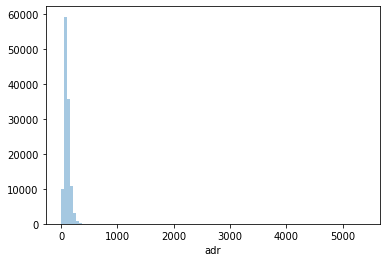

In [221]:
#adr histogram
sns.distplot(df.adr, bins=100, kde=False);

Cancellations

In [ ]:
#canceled prop
print(df.groupby(['hotel'])['is_canceled'].mean() )
df.groupby(['hotel','is_canceled']).agg(
    avg_ = pd.NamedAgg(column= 'adr', aggfunc= 'mean')  ,
    sum_adr = pd.NamedAgg(column = 'adr' , aggfunc = 'sum'),
    freq =  pd.NamedAgg(column = 'adr' , aggfunc = 'count' )
    )

hotel
City Hotel      0.417270
Resort Hotel    0.277634
Name: is_canceled, dtype: float64


avg_     sum_adr   freq
hotel        is_canceled                               
City Hotel   0            105.745948  4888423.70  46228
             1            104.687920  3465379.54  33102
Resort Hotel 0             90.788971  2627251.23  28938
             1            105.787010  1176563.13  11122

#Clean Data

##Drop or Replace NA

In [222]:
#replace country na --> unknown
df.country.fillna('unknown' , axis = 0 , inplace = True)
#df[df.country.isnull() == True]
to_del = df[df.adr.isnull() == True].index
df.drop( to_del , inplace = True)
#fill value for bookings without an agent or company
df.agent.fillna(value= 0 , axis = 0 , inplace = True)
df.company.fillna(value= 0 , axis = 0 , inplace = True)

In [223]:
#fill value for bookings without an agent or company
df.agent.fillna(value= 0 , axis = 0 , inplace = True)
df.company.fillna(value= 0 , axis = 0 , inplace = True)
#fill missng value
df.children.fillna(value = 0 ,axis = 0 ,inplace = True)
pd.Series(df.agent.unique() ).count()

334

##Find Outliers

Remove outlier & anomalies

In [224]:
#del outliers in adr
to_del = df[df.adr > 5000].index
df.drop( to_del ,axis=0 , inplace = True)

to_del = df[df.adr <= 25].index
df.drop( to_del ,axis=0 , inplace = True)

#del outliers in babies
to_del = df.babies[df.babies > 3].index
df.drop( to_del ,axis=0 , inplace = True)

#del outliers in children
to_del = df.children[df.children > 3].index
df.drop( to_del ,axis=0 , inplace = True)

#zero humans in the room
to_del = df[ (df.adults + df.children + df.babies) <= 0 ].index
df.drop( to_del ,axis=0 , inplace = True)

#repalce SC & Undefined to one category
df.loc[(df.meal == 'SC')| (df.meal == 'Undefined'), 'meal'] = 'SC_Undefined'


In [225]:
# df.babies[df.babies > 3]#.plot(kind = 'hist' , bins = 10)
# df[['adr']][ (df.adults <1) & (df.is_canceled ==0) & ( (df.children == 1) | (df.babies > 0) )  ].min()#.plot(kind = 'hist' )
# #df[['adults','children', 'babies','reservation_status','is_canceled','adr']][df.adults <1]#.plot(kind = 'hist' )

#New Columns \ Feature Engineering

In [226]:
df['is_resort'] =  df.hotel.map(lambda x : 1 if x == 'Resort Hotel' else 0  )
#df['is_resort']

In [227]:
#get season function
def get_season(month_str):
    if month_str in ('October', 'November', 'December','January', 'February', 'March'):
        x = 'winter'
    elif month_str in ('July', 'August'):
        x = 'summer'
    elif month_str in ('September','June'):
        x = 'near_summer'
    else: 
        x = 'spring'
    return (x)
#apply season
df['season'] = df.arrival_date_month.apply(get_season)

In [228]:
df['has_company'] = df.company != 0
df['has_agent'] = df.agent != 0

In [229]:
###create arrival_date col
#change month str to int
df['month_number'] = df.arrival_date_month.apply(lambda x: datetime.datetime.strptime(x,'%B').month )
#edit df for 'to_datetime' function
temp = df[['arrival_date_year','month_number','arrival_date_day_of_month']]
temp.rename({'arrival_date_year' : 'year' ,'month_number':'month' , 'arrival_date_day_of_month' : 'day'  } ,axis = 1 , inplace = True)
#create date
df['arrival_date'] = pd.to_datetime(temp)
df['arrival_year_month'] = df.arrival_date.dt.strftime('%Y-%m')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [230]:
#check if date is an holiday
cal = calendar()
holidays = cal.holidays(start = min(df.arrival_date) ,end =  max(df.arrival_date))
df['is_holiday'] = df['arrival_date'].isin(holidays)

In [231]:
#Create adr_bins column
df = df.assign(adr_bins = pd.cut(df["adr"], [0,50,100,150,200,250,300 ,350 , 10000], 
                        labels=['0 to 50', '50 to 100', '100 to 150', '150 to 200', '200 to 250', '250 to 300', '300 to 350' , '350+']) )

In [232]:
df['total_nights'] = df.stays_in_weekend_nights + df.stays_in_week_nights
df['is_weekend'] = df.stays_in_weekend_nights > 0 
df['prop_weekend'] = df.stays_in_weekend_nights / df.total_nights
df['total_guests'] = df.adults + df.children + df.babies
df['has_babies'] = df.babies > 0

#Main EDA

##Country

country distribution

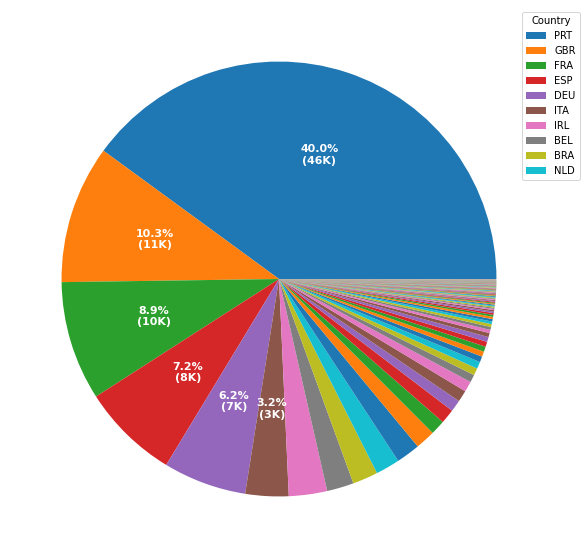

In [233]:
paint = df.country.value_counts().sort_values(ascending = False)

fig, ax = plt.subplots()

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals))/1000)
    return f"{pct:.1f}%\n({absolute:d}K)"  if pct > 3 else ''

wedges, texts, autotexts = ax.pie(paint.values, autopct=lambda pct: func(pct, paint.values),
                                  textprops=dict(color="w"))

#plt.pyplot.rc('legend',fontsize=12 , title_fontsize = 20 , loc = 'upper left')
plt.setp(autotexts, size= 11, weight="bold" )

paint.plot(figsize = (10,10) ).legend(
          wedges, list(paint.index)[0:10],
          title="Country",
          bbox_to_anchor=(1, 1), loc='upper center'
          )
#ax.set_title(" Freq Distribution of Top 10 Organisms (out of 59)" , fontsize = 20) #                    

In [234]:
#aggregate by country
df_agg_country = df.groupby(['country'] ).agg( 
    freq = pd.NamedAgg(column= 'adr', aggfunc= 'count'),  
    avg_adr = pd.NamedAgg(column= 'adr', aggfunc= 'mean'),
    sum_adr = pd.NamedAgg(column= 'adr', aggfunc= 'sum') )
#Calculate 'other' categort for country (freq < 100)
other_freq = df_agg_country.loc[df_agg_country.freq < 100]['freq'].sum()
other_sum =  df_agg_country.loc[df_agg_country.freq < 100]['sum_adr'].sum()
other_avg_adr_country = other_sum / other_freq
#drop countries with freq < 100
df_agg_country.drop( df_agg_country.loc[df_agg_country.freq < 100].index ,axis = 0 , inplace = True)
#add 'other' category to df_agg_country
other_df = pd.DataFrame( [ [other_freq , other_avg_adr_country , other_sum] ],
    index = ['Other'] ,columns = ['freq','avg_adr' , 'sum_adr'] ) 
df_agg_country = pd.concat( [df_agg_country , other_df] ,axis = 0)
df_agg_country.drop(columns=['freq' , 'sum_adr'] , inplace = True)


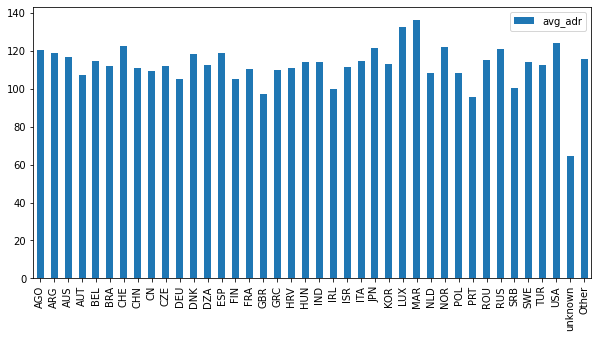

In [235]:
#Avg ADR by Country
df_agg_country.plot( y = 'avg_adr' ,kind = 'bar', figsize = (10,5) )

In [236]:
#merge avg adr for country
df = df.merge(df_agg_country, how="left" ,left_on = 'country' ,right_index = True,  suffixes=("_left", "_right"))
#fill 'other' country avg adr value
df['avg_adr'].fillna(value = other_avg_adr_country , inplace =True)
#rename avg adr -- > country_avg_adr
df.rename({'avg_adr': 'country_avg_adr'} ,axis = 1 , inplace= True)


##Season

Text(1156.2159090909088, 0.5, 'Avg ADR')

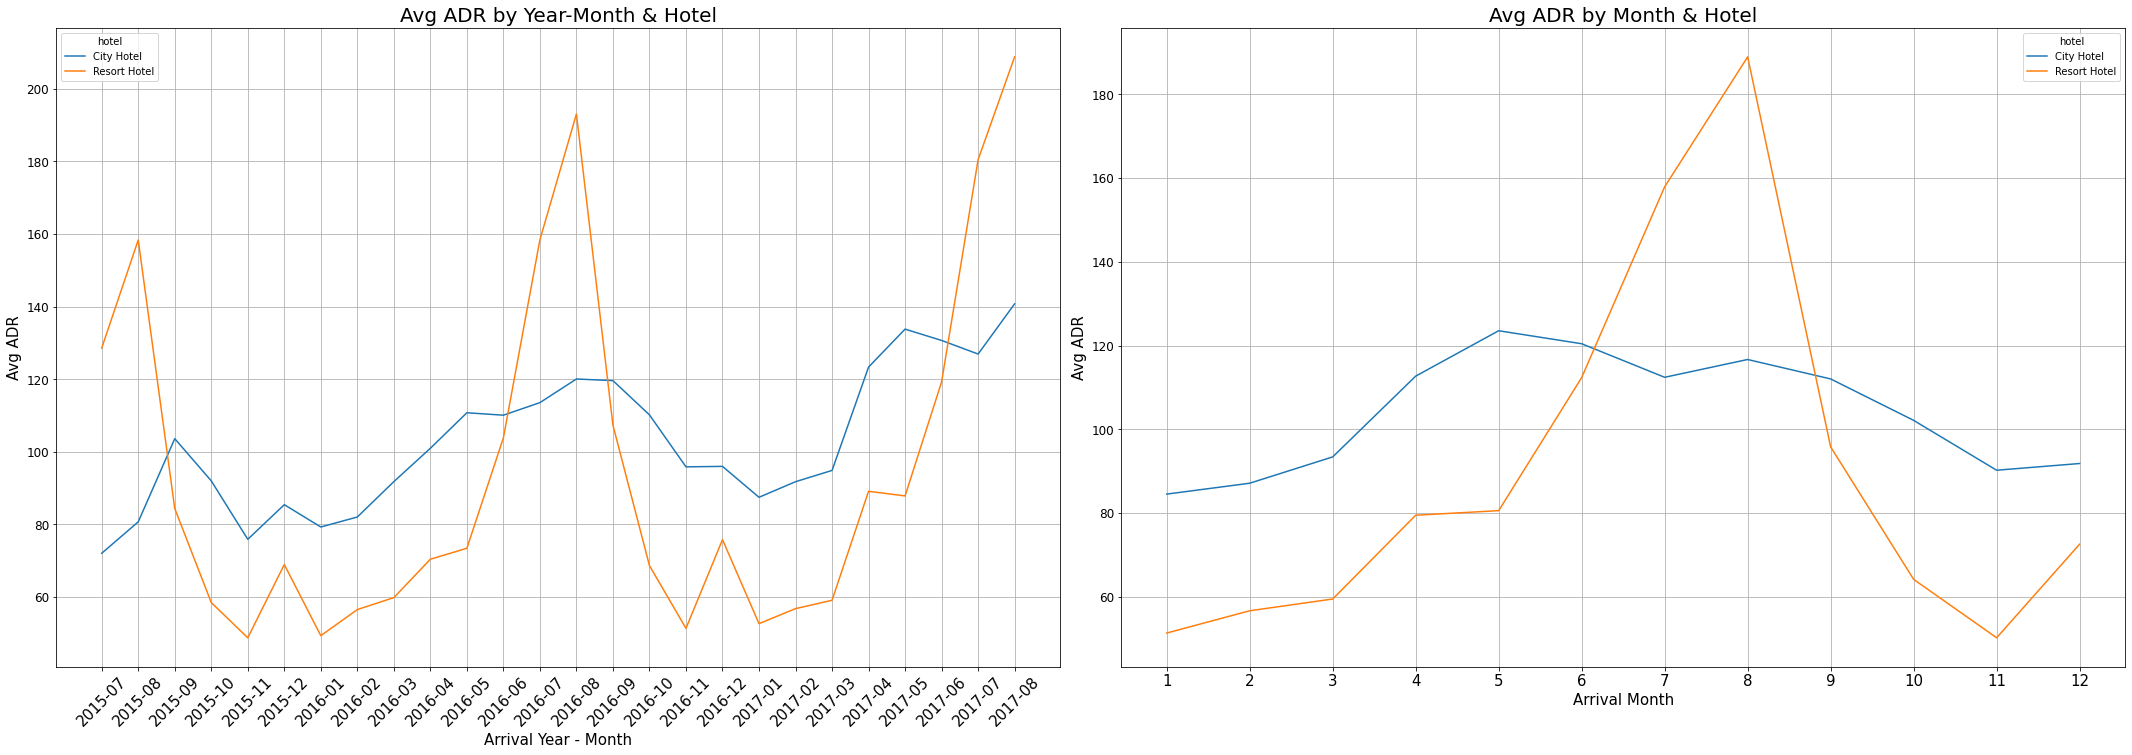

In [237]:
#resort df has more stable seasonality #what we can do with abnormal year(2017)  in city hotel ? #or avg adr increase ?
#split hotels into two df
df_resort = df[df.hotel == 'Resort Hotel']
df_city = df[df.hotel == 'City Hotel']

fig, axes = plt.subplots(nrows= 1 , ncols=2 ,figsize = (30,10) )
fig.tight_layout(pad=3.0 , h_pad= 15.0)

df.groupby( by = ['arrival_year_month','hotel' ])['adr'].mean().unstack().plot(kind = 'line' , ax =axes[0] ,grid = True     )

#Edit plot
plt.sca(axes[0])
#get all xticks lables
plt.xticks(np.arange(len(df.arrival_year_month.unique() ) ), list(df.arrival_year_month.unique() ) , rotation=45, fontsize= 15 )
plt.yticks(fontsize= 12)
axes[0].set_title('Avg ADR by Year-Month & Hotel' , fontsize = 20 )
axes[0].set_xlabel("Arrival Year - Month", fontsize = 15)
axes[0].set_ylabel( 'Avg ADR', fontsize = 15)

#second plot -- only by month
df.groupby( by = ['month_number','hotel' ])['adr'].mean().unstack().plot(kind = 'line' , ax =axes[1] ,xticks = range(1,13) , fontsize= 15 ,grid = True   )

plt.sca(axes[1])
#get all xticks lables
#plt.xticks(np.arange(len(df.month_number.unique() ) ), list(df.month_number.unique() )  )
#Edit plot
plt.yticks(fontsize= 12)
axes[1].set_title('Avg ADR by Month & Hotel' , fontsize = 20 )
axes[1].set_xlabel("Arrival Month", fontsize = 15)
axes[1].set_ylabel( 'Avg ADR', fontsize = 15)





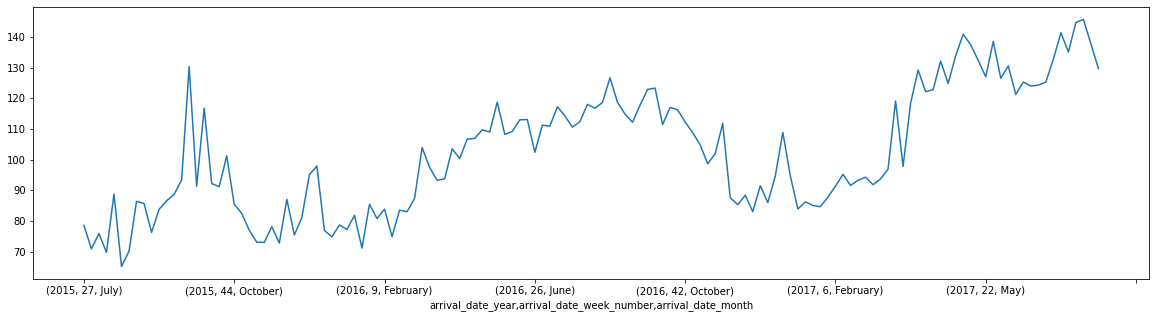

In [238]:
#df city  by year/week/month
df_city.groupby( by = ['arrival_date_year','arrival_date_week_number','arrival_date_month' ])['adr'].mean().plot(figsize = (20,5)  )

##Rooms Types

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


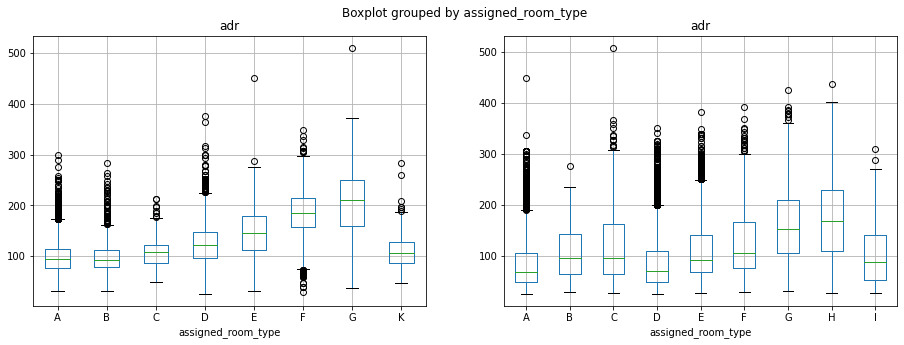

In [326]:
fig, axes = plt.subplots(nrows=1, ncols=2 ,figsize = (15,5) )
plt.tight_layout(pad = 10.0)
df_city.boxplot(column = 'adr' , by = 'assigned_room_type' ,grid = True , ax = axes[0]  )
df_resort.boxplot(column = 'adr' , by = 'assigned_room_type' , grid = True , ax = axes[1]  )

#why the resort is always have lower mdeian and more 'outliers' ?

#Choose Features for the Model

In [239]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'is_resort', 'season',
       'has_company', 'has_agent', 'month_number', 'arrival_date',
       'arrival_year_month', 'is_holiday', 'adr_bins', 'total_nights',
       'is_weekend', 'prop_weekend', 'total_guests', 'has_babies',
       'country_avg_adr'],
      dtype='object')

In [240]:
#split hotels into two df
df_resort = df[df.hotel == 'Resort Hotel']
df_city = df[df.hotel == 'City Hotel']

In [241]:
#convert col 'month number' to string for dummies transformation
df.month_number = df.month_number.astype(str)

In [242]:
# #test model when diff outliers removed
# to_del = df[df.adr > 275].index
# df.drop( to_del ,axis=0 , inplace = True)
# #df.adr[df.adr >275].shape
# #587/116770

In [243]:
df_to_model = df[['is_resort' , 'month_number' , 'lead_time' ,'arrival_date_week_number' ,'distribution_channel' ,'customer_type' 
                  ,'has_company' ,'has_agent' ,'market_segment' ,'country_avg_adr' ,'is_holiday'  , 'previous_cancellations','previous_bookings_not_canceled'
                  ,'adults', 'children', 'babies', 'meal' ,'is_repeated_guest' , 'required_car_parking_spaces'
                , 'reserved_room_type' ,'total_nights','is_weekend', 'prop_weekend','adr']]

In [244]:
# df_to_model = df_city[['is_resort' , 'season' , 'lead_time' ,'has_company' ,'has_agent' ,'market_segment' ,'country_avg_adr' ,'is_holiday'
#                   ,'adults', 'children', 'babies', 'meal' ,'is_repeated_guest' , 'required_car_parking_spaces'
#                 , 'reserved_room_type' , 'stays_in_weekend_nights' , 'stays_in_week_nights','adr']]

In [245]:
df_to_model = pd.get_dummies(df_to_model , drop_first= True)
#df_to_model

In [246]:
X = df_to_model.drop(columns= ['adr'])
y = df_to_model.adr

split to test tran

In [247]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.3, random_state=123456) #148217)

In [248]:
class My_Model():
    def __init__(self):
        self.cat_list = []
        self.dict_exec_model = {'mlr': 'LinearRegression().fit(X_train, y_train)' ,  'knn': 'KNeighborsRegressor(n_neighbors= n_neighbors).fit(X_train, y_train)'
                                ,'tree':'DecisionTreeRegressor( min_samples_leaf = min_samples_leaf, ccp_alpha= ccp_alpha, max_leaf_nodes= max_leaf_nodes,max_depth= max_depth  ).fit(X_train, y_train)'
                                }
### models fit #####
    def fit(self, X ,y  ,model = 'mlr' ,cat='' , n_neighbors = 5
                    #parameters for tree:
                    ,min_samples_split = 2
                    ,splitter = 'best'
                    ,min_samples_leaf = 10, 
                     ccp_alpha = 0.01, 
                     max_leaf_nodes =1000,
                     max_depth =10):       
        # if cat == '' and model in ['mlr','tree','knn']:
        #     setattr(My_Model,f'{model}_general_model' , LinearRegression().fit(X_train, y_train) )
        self.cat = cat
        self.cat_list = X[cat].unique()
        for cat_v in self.cat_list:
            X_train = X.loc[X[cat] == cat_v]
            y_train = y.loc[X_train.index]
            if model == 'mlr':
                setattr(My_Model,f'mlr_{cat_v}_model' , LinearRegression().fit(X_train, y_train) )
            elif model == 'tree':
                setattr(My_Model,f'tree_{cat_v}_model' 
                       ,DecisionTreeRegressor( 
                              min_samples_split = min_samples_split ,
                              splitter = splitter ,
                              min_samples_leaf = min_samples_leaf, 
                              ccp_alpha= ccp_alpha, 
                              max_leaf_nodes= max_leaf_nodes,
                              max_depth= max_depth  ).fit(X_train, y_train) )
            else:
                 setattr( My_Model,f'knn_{cat_v}_model' , KNeighborsRegressor(n_neighbors= n_neighbors).fit(X_train, y_train) )

#####predictions #####
    def predict(self ,X ,model = 'mlr'):
         y_pred = pd.Series(name='y_pred' ,dtype = 'float64')
         for cat_v in self.cat_list:
             X_predict = X.loc[X[self.cat] == cat_v]
             cat_v_pred =  eval(f'self.{model}_{cat_v}_model.predict(X_predict)') 
             cat_v_pred = pd.Series(cat_v_pred, X_predict.index)
             y_pred = pd.concat( [y_pred , cat_v_pred] ,axis = 0 ,names=['y_pred'] )
         return y_pred    

#Models

##Linear Regression

First_model - all df observations

 mse_train : 29.110956733197224


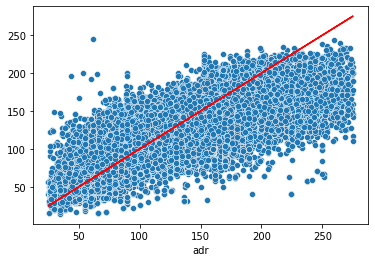

In [249]:
First_model = LinearRegression().fit(X_train , y_train)
y_train_pred = First_model.predict(X_train)
ax = sns.scatterplot(x=y_train, y=y_train_pred )
ax.plot(y_train, y_train, 'r')
mse_train = mse(y_train, y_train_pred , squared= False)
print(f' mse_train : {mse_train}')

###Fit &Predict

In [250]:
lr_model = My_Model()

In [251]:
lr_model.fit(X_train , y_train ,model = 'mlr', cat = 'is_resort')

In [252]:
y_train_pred = lr_model.predict(X_train ,model = 'mlr')

In [253]:
#sort y index
y_train_pred.sort_index(inplace=True)
y_train.sort_index(inplace = True)

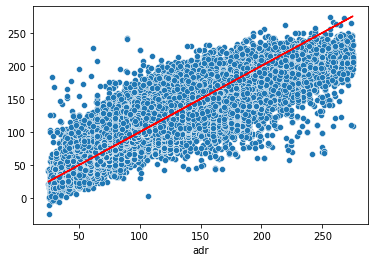

In [254]:
ax = sns.scatterplot(x=y_train, y=y_train_pred )
ax.plot(y_train, y_train, 'r')

In [255]:
mse_train = mse(y_train, y_train_pred , squared= False)
print(mse_train)

23.365000295972447


In [ ]:
#parameters of the model
#model 0 --> city hotel
print(lr_model.mlr_0_model.intercept_)
zipped = zip(X_train.columns, lr_model.mlr_0_model.coef_)
zipped_sorted = sorted(zipped, key = lambda x : abs(x[1])  , reverse  = True)
zipped_sorted


###Validation

In [257]:
y_test_pred = lr_model.predict(X_test, model = 'mlr')

In [258]:
y_test_pred.sort_index(inplace=True)
y_test.sort_index(inplace=True)

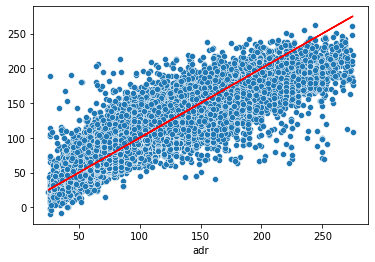

In [259]:
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [260]:
mse_test = mse(y_test , y_test_pred , squared= False)
print(mse_test)
#mse_difference
mse_train - mse_test

23.468001796313963


-0.10300150034151656

##Decision Tree

In [ ]:
#on all df
#tree_model = DecisionTreeRegressor(min_samples_leaf=10, 
#                               ccp_alpha=0.01 
#                               ,max_leaf_nodes=1000
#                               ,max_depth=100
#                               )
# tree_model.fit(X_train, y_train)

In [261]:
My_Model_tree = My_Model()
My_Model_tree.fit(X_train , y_train ,model ='tree' ,cat ='is_resort'
                              ,splitter = 'best'
                              ,min_samples_split = 40
                              ,min_samples_leaf=10
                              ,ccp_alpha=0.01 
                              ,max_leaf_nodes=1000
                              ,max_depth=100)




In [262]:
#visualize_tree(My_Model_tree.tree_0_model ,fs = (25,15))

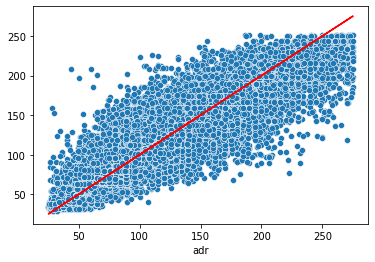

In [263]:
y_train_pred = My_Model_tree.predict(X_train ,model ='tree' )                             
#sort y index
y_train_pred.sort_index(inplace=True)
y_train.sort_index(inplace = True)
#plot
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [264]:
mse_train = mse(y_train, y_train_pred , squared= False)
print(mse_train)

16.77431381105903


Validate

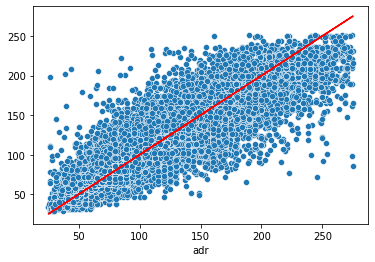

In [265]:
y_test_pred = My_Model_tree.predict(X_test , model ='tree')
#sort y index
y_test_pred.sort_index(inplace=True)
y_test.sort_index(inplace = True)
#plot
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [266]:
mse_test = mse(y_test , y_test_pred , squared= False)
print(mse_test)
#mse_difference
mse_train - mse_test

18.961489399437035


-2.187175588378004

Feature Importances

In [322]:
#sum(My_Model_tree.tree_0_model.feature_importances_)
zipped = zip(X.columns, My_Model_tree.tree_0_model.feature_importances_) #city model = 0 ,resort =1
zipped_sorted = sorted(zipped, key = lambda x : x[1]  , reverse  = True)
for feature, importance in zipped_sorted:
    if importance > 0.001:
        print(f'{feature:12}: {round( importance ,4) }')

reserved_room_type_F: 0.1531
adults      : 0.1531
arrival_date_week_number: 0.1515
lead_time   : 0.0972
market_segment_Online TA: 0.0705
meal_HB     : 0.045
market_segment_Direct: 0.0384
reserved_room_type_E: 0.0338
reserved_room_type_G: 0.0318
reserved_room_type_D: 0.0308
total_nights: 0.0306
month_number_6: 0.0197
month_number_5: 0.0179
market_segment_Groups: 0.014
country_avg_adr: 0.0133
children    : 0.0125
meal_SC_Undefined: 0.0118
market_segment_Offline TA/TO: 0.011
prop_weekend: 0.0109
month_number_9: 0.008
month_number_4: 0.0065
has_agent   : 0.0061
customer_type_Transient: 0.0055
month_number_3: 0.005
previous_cancellations: 0.0037
is_weekend  : 0.0033
month_number_8: 0.003
market_segment_Corporate: 0.0025
distribution_channel_TA/TO: 0.002
month_number_10: 0.0018
previous_bookings_not_canceled: 0.0013


In [324]:
zipped = zip(X.columns, My_Model_tree.tree_1_model.feature_importances_) #city model = 0 ,resort =1
zipped_sorted = sorted(zipped, key = lambda x : x[1]  , reverse  = True)
for feature, importance in zipped_sorted: 
    if importance > 0.001:
        print(f'{feature:12}: {round( importance , 4) }')

month_number_8: 0.3532
month_number_7: 0.2359
market_segment_Offline TA/TO: 0.0545
children    : 0.0516
month_number_6: 0.049
lead_time   : 0.04
arrival_date_week_number: 0.0358
month_number_9: 0.0256
meal_HB     : 0.0235
adults      : 0.0211
reserved_room_type_E: 0.0125
reserved_room_type_G: 0.0123
country_avg_adr: 0.0105
month_number_4: 0.0075
reserved_room_type_D: 0.0066
month_number_5: 0.0065
market_segment_Online TA: 0.0061
total_nights: 0.0057
meal_SC_Undefined: 0.0049
reserved_room_type_H: 0.0049
reserved_room_type_F: 0.0041
market_segment_Direct: 0.004
prop_weekend: 0.0034
meal_FB     : 0.0034
market_segment_Corporate: 0.0032
has_agent   : 0.0028
month_number_10: 0.0016
customer_type_Transient-Party: 0.0015
distribution_channel_Direct: 0.0012
required_car_parking_spaces: 0.0012
reserved_room_type_C: 0.0011


In [ ]:
zipped = zip(X.columns, My_Model_tree.tree_1_model.feature_importances_)
zipped_sorted = sorted(zipped, key = lambda x : x[1]  , reverse  = True)


## K-Nearest Neighbors

In [ ]:
#is_resort = X_train.is_resort
# sc_X = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.transform(X_test)

In [ ]:
# X_train = pd.DataFrame(X_train)
# X_train = pd.concat( [X_train , is_resort] ,axis = 1)

####X_train.dropna(inplace = True)

In [281]:
knn_model = My_Model()
knn_model.fit(X_train, y_train , model = 'knn' , cat = 'is_resort' , n_neighbors = 9)
#old way
#knn_model = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

In [282]:
y_train_pred = knn_model.predict(X_train , model = 'knn')

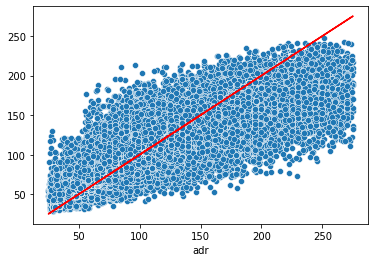

In [283]:
#sort y
y_train_pred.sort_index(inplace=True)
y_train.sort_index(inplace = True)
#plot
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [284]:
mse_train = mse(y_train, y_train_pred , squared= False)
print(mse_train)

24.58010605551041


validate

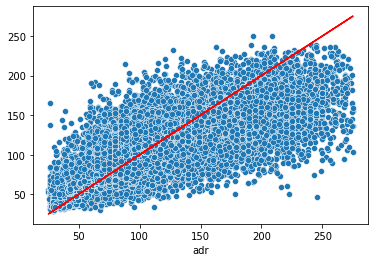

In [285]:
#test pred
y_test_pred = knn_model.predict(X_test ,model = 'knn')
#sort y
y_test_pred.sort_index(inplace=True)
y_test.sort_index(inplace = True)
#plot
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [286]:
mse_test = mse(y_test , y_test_pred , squared= False)
print(mse_test)
#mse_difference
mse_train - mse_test

27.828604102442323


-3.248498046931914